# Wordle


首先引入需要的库，定义文件存储位置和一些常量

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

DATA_DIR = "data"
IMG_DIR = "img"
WORDLE_DATA_FILE = os.path.join(DATA_DIR, "data.xlsx")

## 第一问

### 题目概览

**English**

The number of reported results vary daily. Develop a model to explain this variation and use your model to create a prediction interval for the number of reported results on March 1, 2023. Do any attributes of the word affect the percentage of scores reported that were played in Hard Mode? If so, how? If not, why not?

**中文**

报告结果的数量每天都在变化。建立一个模型来解释这种变化，并使用你的模型为2023年3月1日的报告结果数量建立一个预测区间。词语的任何属性是否影响到报告的在困难模式下进行的分数的百分比？如果是，如何影响？如果没有，为什么没有？


- 建立模型，解释变化原因、建立预测区间

- 分析词语的属性是否影响了report number of hard/totol report number, 解释原因

### 解题思路

**模型选择**

本题是与时间相关的预测问题，对随时间变化的数据进行建模和预测可以考虑使用时间序列预测模型。

根据数据，报告数量随着时间有先增后减的变化，从wordle游戏的背景上来看，这显然是由于wordle这个游戏在社交网络上爆火所造成的。在突发事件导致时间序列数据先增后减的情况下，如果突发事件对后续数据产生了持续性影响，即使数据出现了变化，也不需要进行平稳化处理。这是因为平稳化处理的目的是消除时间序列数据的趋势和季节性变化，使数据更加稳定。但如果突发事件导致了持续性影响，这种稳定性就失去了意义。

因此，在这种情况下，需要建立时间序列模型时，可以考虑使用带有趋势项的模型，如ARIMA模型。这样可以较好地捕捉数据的趋势变化，进而进行预测。当然，建立模型时，需要根据数据的特点进行具体选择，并结合模型的诊断结果进行优化调整，以提高预测的准确性。

> 模型背景补充：
> 自回归积分移动平均模型（ARIMA）是一种用于时间序列分析和预测的经典方法，它通过对时间序列数据的自相关性、差分运算和移动平均来捕捉时间序列的模式，并进行预测。在 ARIMA 模型中，自回归部分 AR 用于捕捉序列的自相关性，移动平均部分 MA 用于捕捉序列的滞后效应，积分部分 I 用于处理非平稳时间序列。
>
> ARIMA 模型在一定程度上可以用于预测时间序列的趋势。具体而言，ARIMA 模型中的 AR 部分和 I 部分可以用于捕捉时间序列的长期趋势，而 MA 部分可以用于捕捉时间序列的短期波动。因此，当时间序列的趋势较为平滑且没有明显的季节性波动时，ARIMA 模型可以通过调整其参数来预测时间序列的趋势。但是，在时间序列存在较为明显的季节性波动时，ARIMA 模型的预测效果可能会受到影响。
> 
> 需要注意的是，ARIMA 模型的预测效果还受到很多因素的影响，例如时间序列的数据质量、模型参数的选择、模型的拟合效果等。在使用 ARIMA 模型进行趋势预测时，需要对时间序列数据进行适当的处理和模型参数的调整，以获得更准确的预测结果。



题目数据中一共有359天的数据，考虑使用320天数据作为训练集，30天数据作为测试集。模型训练完成后直接预测3月1日。

**模型测试**

一共使用两种数据进行模型测试：

- 使用预先分配出来的测试集的数据进行测试

- 使用网络爬取的wordle单词搜索热度（搜索结果条数）进行测试，具体方法：归一化+距离度量

**TODO LIST**

- [ ] ARIMA时间序列预测，模型建立与训练
- [ ] 爬取wordle每日热度，制作每日热度图
- [x] 模型测试

首先先来看一下题目给出的数据，绘制日期和总报告数量的趋势图

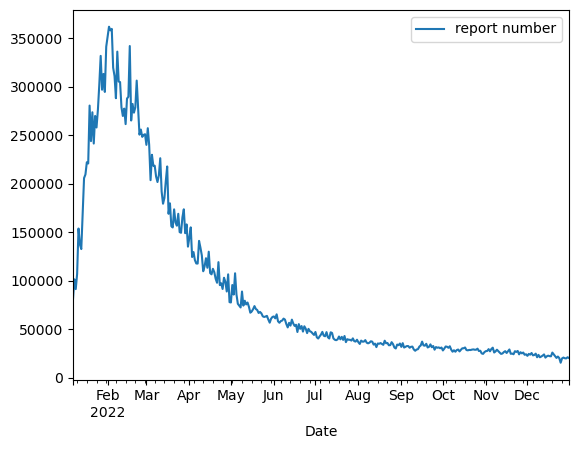

<Figure size 640x480 with 0 Axes>

In [67]:
df = pd.read_excel(WORDLE_DATA_FILE)
df = df[['Date', 'Total-num-repo']]
df.columns = ['Date','report number']
df = df.sort_values(by='Date', ascending=True)
df.reset_index(drop=True, inplace=True)
# 绘制趋势图
df.set_index("Date").plot()
plt.show()
plt.savefig(os.path.join(IMG_DIR, "arima.png"))  

原始数据是时间序列相关数据，首先要对数据的随机性和平稳性进行检测，这两个检测是时间序列预测的重要部分。根据不同检测结果需要采取不同的分析方法。

>  为什么时间序列要求平稳性呢？平稳性就是要求由样本拟合出的曲线在未来一段时间内仍然能够以现有的形态和趋势发展下去，这样预测结果才会有意义。
>
> 对于平稳序列， 它的均值和方差是常数， 现已有一套非常成熟的平稳序列的建模方法。 通常是建立一个线性模型来拟合该序列的发展 借此提取该序列的有用信息。
>
> 对于非平稳序列， 由于它的均值和方差不稳定， 处理方法一般是将其转变为平稳序列，这样就可以应用有关平稳时间序列的分析方法， 如建立ARIMA模型来进行相应的研究，或者分解趋势与季节性等并根据情况应用指数平滑模型等。
> 
> 对于纯随机序列，又称为白噪声序列，序列的各项之间没有任何相关关系，序列在进行完全无序的随机波动，可以终止对该序列的分析。白噪声序列是没有信息可提取的平稳序列。


前面从主观的数据趋势初步确定了需要使用ARIMA进行时间序列预测，为了确定是否真的可以使用这个模型，我们需要先对数据的平稳性和随机性进行检验。

### 平稳时间序列的检验

目前，对时间序列的平稳性检验主要有两种方法，一种是图检法，即根据时序图和自相关图进行直观判断，另一种是构造检验统计量的方法，有单位根检验法等方法。

**图检法**

我们可以通过自相关图来进行检验，对于平稳时间序列，其自相关图一般随着阶数的递增，自相关系统会迅速衰减至0附近，而非平稳时间序列则可能存在先减后增或者周期性波动等变动。

参考文章：
[时间序列（二）：时间序列平稳性检测](https://smilecoc.vip/2021/01/15/time_series_part2_stability/)

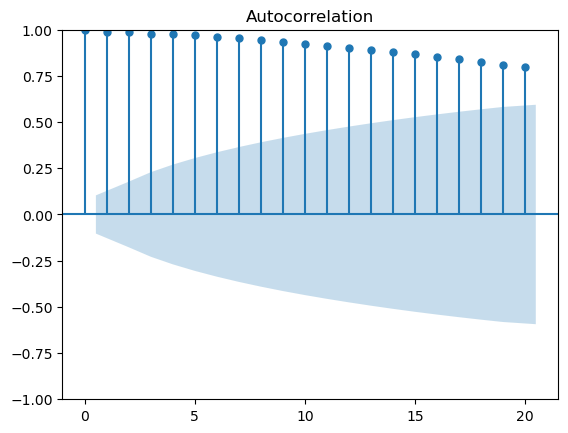

<Figure size 640x480 with 0 Axes>

In [68]:
# 绘制自相关图
# total_log = np.log(total_num_repo)
# total_log_diff = total_log.diff(1).dropna()
tsaplots.plot_acf(df['report number'], lags=20)  # lags为滞后阶数
plt.show()
plt.savefig(os.path.join(IMG_DIR, "arima_acf.png"))

如上图所示，该时间序列随着阶数的递增，自相关系数递减至零，因此可以判断该时间序列是平稳时间序列。

**统计检验方法**

当然，图检验法具有一定的主观因素，我们使用单位根平稳检验作为定量验证。

> 迪基-福勒（Dickey Fuller）检验是最流行的统计检验方法之一，可以用它来确定序列中单位根的存在，从而帮助判断序列是否是平稳。ADF检验是对DF检验的扩展。参考[ADF（增补迪基-福勒）检验](https://smilecoc.vip/2021/01/15/time_series_part2_stability/#ADF%EF%BC%88%E5%A2%9E%E8%A1%A5%E8%BF%AA%E5%9F%BA-%E7%A6%8F%E5%8B%92%EF%BC%89%E6%A3%80%E9%AA%8C)

In [69]:
#定义ADF输出格式化函数
def adf_test(timeseries):
    print ('ADF检验结果:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
 
#对数据集使用ADF检验
adf_test(df['report number'])

ADF检验结果:
Test Statistic                  -3.920340
p-value                          0.001890
Number of Lags Used             17.000000
Number of Observations Used    341.000000
Critical Value (1%)             -3.449673
Critical Value (5%)             -2.870053
Critical Value (10%)            -2.571306
dtype: float64


ADF的结果主要看以下两个方面：

> - Test Statistic的值如果比Critical Value (5%)小则满足稳定性需求.
> - p-value越低（理论上需要低于0.05）证明序列越稳定。

在上面的检测结果中，test statistic < Critical Value (5%) ，这意味着序列是平稳的。同时p值为0.002791,这证实了我们最初在目视检测中观察的结果。

**至此，我们确定了原始数据是一个平稳的时间序列**

### 随机性检验

对于纯随机序列，又称白噪声序列，序列的各项数值之间没有任何相关关系，序列在进行完全无序的随机波动，可以终止对该序列的分析。白噪声序列是没有信息可提取的平稳序列。**白噪声检验原假设：时间序列是白噪声。**
下面进行原始数据集的白噪音检测，输出检验结果中会返回两个值：
lbvalue: 测试的统计量 和 pvalue: 基于卡方分布的p统计量。如果p-value>0.05则可判断为白噪声序列

In [70]:
#白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(df['report number'])

,lb_stat,lb_pvalue
1,353.938287,5.882139e-79
2,706.228372,4.410192e-154
3,1054.647191,2.512911e-228
4,1401.354779,3.514096e-302
5,1745.171936,0.000000e+00
6,2084.873529,0.000000e+00
7,2419.088020,0.000000e+00
8,2748.281023,0.000000e+00
9,3070.153991,0.000000e+00
10,3385.123326,0.000000e+00


可以发现白噪音检测得到的卡方检验p-value值远小于0.05，因此拒绝原假设，即时间序列不是白噪声。
至此，我们证明了原始数据序列是平稳的非白噪声序列。

### 平稳时间序列建模

**模型定阶**

对于复杂的ARMA(p,q)模型，难以用自相关函数和偏自相关函数确定阶数，可以网格搜索法：对于给定的时间序列数据，可以通过构建所有可能的ARIMA模型，并通过交叉验证选择最佳的模型参数。可以使用Python中的pmdarima库中的auto_arima函数来进行网格搜索。

In [71]:
from pmdarima.arima import auto_arima

# 使用auto_arima选择最佳模型参数
model = auto_arima(df['report number'], start_p=1, start_q=1, max_p=3, max_q=3, 
                   start_P=0, seasonal=True, d=0, D=0, trace=True, error_action='ignore', 
                   suppress_warnings=True, stepwise=True)

# 输出选择的最佳模型参数
print(model.order)
print(model.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7775.904, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9206.192, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7817.249, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8971.404, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9460.614, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=7772.151, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=7773.254, Time=0.34 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7774.083, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=7776.039, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=7776.297, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=7770.828, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7774.625, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=i

这里的 ARIMA(2,0,1)(0,0,0)[0] 表示使用 ARIMA 模型进行拟合时，得到的最佳模型的参数是 (2,0,1) 和 (0,0,0,0)。

(2,0,1) 表示 ARIMA 模型中的三个参数：p, d, q。其中，p 是自回归项数，d 是差分次数，q 是移动平均项数。这里的 (2,0,1) 意味着 ARIMA 模型选择了 2 个自回归项，0 次差分和 1 个移动平均项。
(0,0,0,0) 表示季节性 ARIMA 模型（SARIMA）的四个参数：P, D, Q, m。其中，P 是季节性自回归项数，D 是季节性差分次数，Q 是季节性移动平均项数，m 是季节长度。这里的 (0,0,0,0) 表示该模型不考虑季节性。
在 ARIMA 模型中，[0] 表示使用不使用常数项（也叫截距项）进行建模。在这个例子中，[0] 表示不使用常数项。

因此，我们得到的 Best model: ARIMA(2,0,1)(0,0,0)[0] 的意思是，最佳模型的参数是 (2,0,1) 和 (0,0,0,0)，它不考虑季节性，且不使用常数项。

接下来，我们使用这个模型参数拟合模型并完成预测和评估，我们采用前80%数据作为训练集，后20%作为测试集。

In [72]:
from statsmodels.tsa.arima.model import ARIMA
# 将数据分成了训练集和测试集
train_data = df['report number'][:320]
test_data = df['report number'][320:]
# print(test_data)
# 创建 ARIMA 模型对象
# p=2, d=1, q=1 表示 ARIMA(2, 1, 1) 模型
model = ARIMA(train_data, order=(4, 1, 2))
# 使用训练集拟合 ARIMA 模型
model_fit = model.fit()
# 查看模型拟合结果
print(model_fit.summary())

/home/huangrui/miniconda3/envs/d2l/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/huangrui/miniconda3/envs/d2l/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:          report number   No. Observations:                  320
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -3448.622
Date:                Sat, 18 Feb 2023   AIC                           6911.244
Time:                        17:36:06   BIC                           6937.600
Sample:                             0   HQIC                          6921.769
                                - 320                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0184      0.085     12.027      0.000       0.852       1.184
ar.L2         -0.0841      0.054     -1.551      0.121      -0.190       0.022
ar.L3         -0.1658      0.053     -3.130      0.0

float64


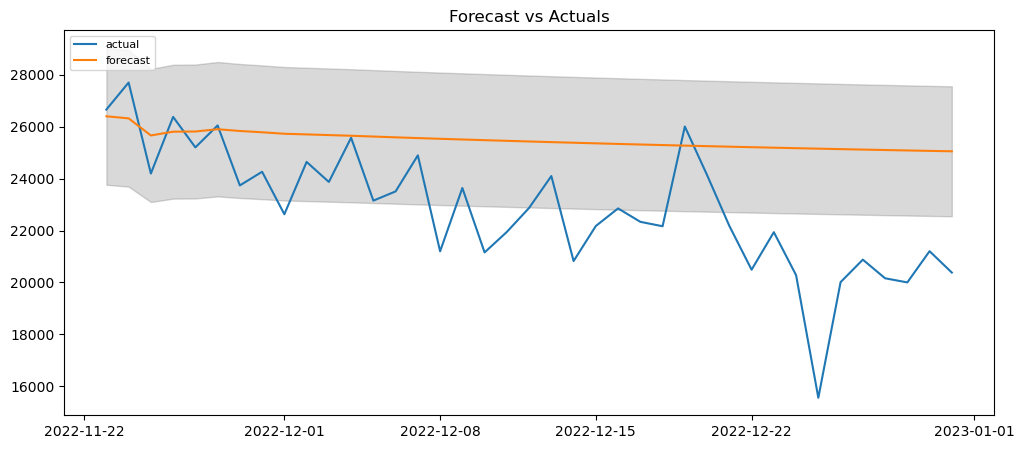

In [78]:
# 对测试集中的数据进行预测
fc = model_fit.forecast(39, alpha=0.05)
print(fc.dtypes)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = fc_series * 0.90
upper_series = fc_series * 1.10
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
# 打印预测结果
# Plot
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(df['Date'][-50:], train_data[-50:], label='training')
plt.plot(df['Date'][-39:],test_data, label='actual')
plt.plot(df['Date'][-39:],fc_series, label='forecast')
plt.fill_between(df['Date'][-39:], lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [79]:
# 计算MSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
pred = fc_series
real = test_data
MSE = mean_squared_error(y_true=real,y_pred=pred) # MSE
MAE = mean_absolute_error(y_true=real,y_pred=pred) # MAE
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE = mean_absolute_percentage_error(y_true=real,y_pred=pred)
print("MSE: ", MSE)
print("MAE: ", MAE)
print("MAPE: ", MAPE,"%")

MSE:  11423576.64432039
MAE:  2792.371907455389
MAPE:  13.294315165070019 %
